In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [2]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[strip(a) for a in split(feature_text,',')]
print len(features),features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [3]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it

from os.path import exists
if not exists('higgs'):
    print "creating directory higgs"
    !mkdir higgs
%cd higgs
if not exists('HIGGS.csv'):
    if not exists('HIGGS.csv.gz'):
        print 'downloading HIGGS.csv.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
    print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
    !gunzip -f HIGGS.csv.gz
!ls -l
%cd ..

/Users/Weichen/code/data_analysis/Homeworks/HW-5/higgs
total 15694336
-rw-r--r--  1 Weichen  staff  8035497980 May 21 15:26 HIGGS.csv
/Users/Weichen/code/data_analysis/Homeworks/HW-5


### As done in previous notebook, create RDDs from raw data and build Gradient boosting and Random forests models. Consider doing 1% sampling since the dataset is too big for your local machine

In [4]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='higgs/higgs.csv'
inputRDD=sc.textFile(path)

In [5]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
     .map(lambda line: LabeledPoint(line.pop(0), line))

### Reducing data size

In [6]:
Data1=Data.sample(False,0.01).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=109981, trainingData=76938, testData=33043


In [7]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(1.0, 17441), (0.0, 15602)]

### Gradient Boosted Trees

In [8]:
from time import time
errors={}

In [9]:
def GBT(depths, numI):
    for depth in depths:
        start=time()
        model=GradientBoostedTrees.trainClassifier(trainingData, {}, numIterations=numI, maxDepth=depth)
        errors[depth]={}
        dataSets={'train':trainingData,'test':testData}
        for name in dataSets.keys():  # Calculate errors on train and test sets
            data=dataSets[name]
            Predicted=model.predict(data.map(lambda x: x.features))
            LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
            Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
            errors[depth][name]=Err
        print depth,errors[depth],int(time()-start),'seconds'
    #print errors

In [11]:
GBT([1,3,6], 10)

1 {'test': 0.38431740459401387, 'train': 0.38545322207491745} 33 seconds
3 {'test': 0.3263020912144781, 'train': 0.3293561049156464} 42 seconds
6 {'test': 0.30463335653542356, 'train': 0.2926642231407107} 70 seconds


In [14]:
GBT([10], 10)

10 {'test': 0.3023635868413885, 'train': 0.19748368816449607} 491 seconds


In [20]:
errors

{1: {'test': 0.38431740459401387, 'train': 0.38545322207491745},
 3: {'test': 0.3263020912144781, 'train': 0.3293561049156464},
 6: {'test': 0.30463335653542356, 'train': 0.2926642231407107},
 10: {'test': 0.3023635868413885, 'train': 0.19748368816449607}}

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


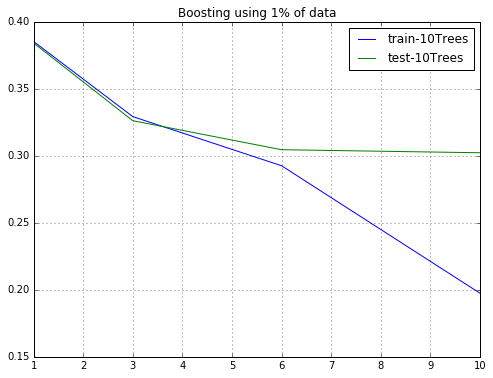

In [21]:
B10 = errors
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 1% of data')

### Random Forests

In [22]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
errors={}

In [23]:
def RF(depths, numT):
    for depth in depths:
        start=time()
        model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                         numTrees=numT, maxDepth=depth)
        errors[depth]={}
        dataSets={'train':trainingData,'test':testData}
        for name in dataSets.keys():  # Calculate errors on train and test sets
            data=dataSets[name]
            Predicted = model.predict(data.map(lambda x: x.features))
            LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
            Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
            errors[depth][name]=Err
        print depth,errors[depth],int(time()-start),'seconds'
    #print errors

In [25]:
RF([1,3,6,10], 15)

1 {'test': 0.3999939472808159, 'train': 0.39894460474667914} 11 seconds
3 {'test': 0.37060799564204217, 'train': 0.3697132756245288} 14 seconds
6 {'test': 0.3198559452834186, 'train': 0.31462996178741326} 37 seconds
10 {'test': 0.29879248252277335, 'train': 0.2627180327016559} 108 seconds


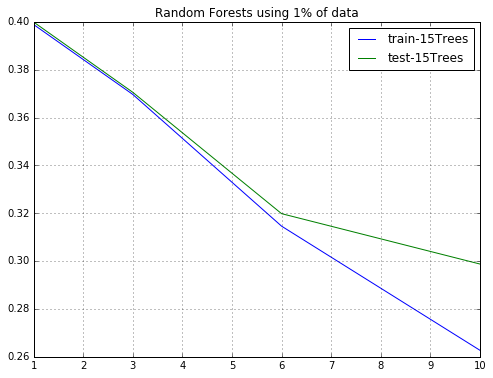

In [26]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['15Trees'],Title='Random Forests using 1% of data')

### Now plot two performance curves in the same graph

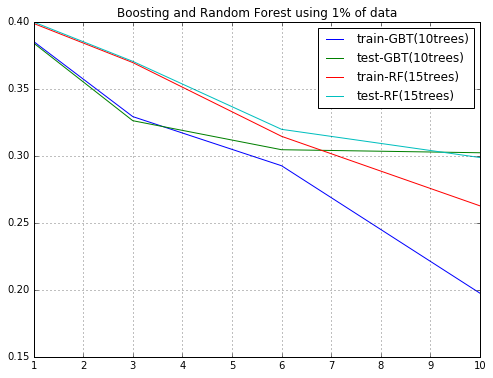

In [27]:
make_figure([B10, RF_10trees],['GBT(10trees)', 'RF(15trees)'],Title='Boosting and Random Forest using 1% of data')